# Derivatives

In order to fit the ideal set of parameters minimizing a cost or loss function, gradient based approaches are quite popular as being aware of the direction in which this cost function is minimized it may shorten the time required for the method to find it target.

Quantum circuits have a similar capacity, we can free up the parameters of a given circuit and optimize based on a cost function which in most cases can be represented by the expectation value over some observable. For this, we would need to understand how these derivatives can be computed... at scale.

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

a = Parameter('a')

qc = QuantumCircuit(1)
qc.ry(a, 0)
qc.draw()

┌───────┐
q: ┤ Ry(a) ├
   └───────┘

This is a simple rotation over the Y axis of the bloch sphere. So we know that if we measure the observable X of a given state produced by this rotation we get:

$$

\langle Y(a) | X | Y(a) \rangle = \sin(\pi a)

$$

In [2]:
import numpy as np
from qiskit.quantum_info import Statevector
 
init = QuantumCircuit(1)
state = Statevector(init)

val = 0.3
circ = qc.assign_parameters({a : np.pi*0.3})
eval = state.evolve(circ)
print(eval)

Statevector([0.89100652+0.j, 0.4539905 +0.j],
            dims=(2,))


In [3]:
from qiskit.quantum_info import Pauli

# Target hamiltonian
op = Pauli('X')

print(f"<Ry|X|Ry> : {eval.expectation_value(oper=op)}")
print(f"Sin function: {np.sin(np.pi * val)}")

<Ry|X|Ry> : 0.8090169943749475
Sin function: 0.8090169943749475


Then we know we could calculate its derivative as $\pi\cos(\pi a)$. This may not be an option for when we go to hardware and we make the circuit much more complicated in terms of gates (in particular multiqubit gates). Enter numerical resolution of derivatives!

We can produce an approximation to our target by leveraging finite differences for numerical approximation, taking into consideration the limit:

$$

f^{'}(a) = \lim_{h \rightarrow 0} \frac{f(a + h) - f(a)}{h}

$$

which essentially only requires two evaluations of our function.

In [4]:
state = Statevector(init)

val = 0.3
h = 0.001

# Get the expectation value for f(x)
circ = qc.assign_parameters({a : np.pi*0.3})
eval = state.evolve(circ)
exp_val = eval.expectation_value(oper=op)

# Get the expectation value for f(x+h)
circ = qc.assign_parameters({a : np.pi*(0.3+h)})
eval = state.evolve(circ)
exp_val_eps = eval.expectation_value(oper=op)

print('Finite difference:', (exp_val_eps - exp_val) / h)
print('Cosine formula:   ', np.pi * np.cos(np.pi * val))

Finite difference: 1.8425864574259654
Cosine formula:    1.8465818304904567


With a varying number of observables and compositions, this is what automatic differentiation frameworks can provide by tracking values and benefitting from the composable nature of the numerical approximations. More information in [https://www.tensorflow.org/quantum/tutorials/gradients#2_the_need_for_a_differentiator](https://www.tensorflow.org/quantum/tutorials/gradients#2_the_need_for_a_differentiator)

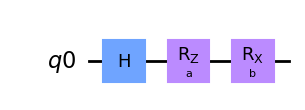

In [5]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter

# Instantiate the quantum circuit
a = Parameter('a')
b = Parameter('b')

# Circuit
q = QuantumRegister(1)
qc = QuantumCircuit(q)
qc.h(q)
qc.rz(a, q[0])
qc.rx(b, q[0])

# Instantiate the Hamiltonian observable 2X+Z
H = SparsePauliOp.from_list([('X', 2), ('Z',1)])

# Parameter list
params = [[np.pi / 4, 0]]

display(qc.draw('mpl', style = "clifford"))

In [6]:
from qiskit.primitives import Estimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

# Define the estimator
estimator = Estimator()
# Define the gradient
gradient = ParamShiftEstimatorGradient(estimator)

# Evaluate the gradient of the circuits using parameter shift gradients
pse_grad_result = gradient.run(qc, H,  params).result().gradients
print('State estimator gradient computed with parameter shift', pse_grad_result)

State estimator gradient computed with parameter shift [array([-1.41421356,  0.70710678])]
